### Wineのサンプルデータに対してGDBTで分類を行う。
### Hyperoptと交差検証でパラメータ調整を行う。

In [1]:
import numpy as np
from hyperopt import hp, tpe, Trials, fmin

RANDOM_SEED=71

# データの用意

In [2]:
from sklearn import datasets

#データの読み込み
wine = datasets.load_wine()
data = wine.data
target = wine.target

# データの標準化処理
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_std = sc.fit_transform(data)

# 教師データ7割と試験データ3割に分割
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X_std, target, test_size=0.3, stratify=target, random_state=RANDOM_SEED)


### 参考として未調整のGDBTによる学習精度を見る

In [7]:
from sklearn import ensemble
model = ensemble.GradientBoostingClassifier(random_state=RANDOM_SEED)
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, f1_score, recall_score
y_pred = model.predict(X_test)
print('Accuracy: %.5f' % accuracy_score(y_test,y_pred))
print('f1      : %.5f' % f1_score(y_test,y_pred, average = 'micro'))
print('recall  : %.5f' % recall_score(y_test,y_pred, average = 'micro'))

Accuracy: 0.94444
f1      : 0.94444
recall  : 0.94444


### パラメータ探索空間と評価関数の設定

In [31]:
# パラメータ探索空間(GBDT)
hyperopt_parameters = {
    # log_uniformは範囲指定(exp(uniform(low, high))のような対数に一様分布)
    'learning_rate': hp.uniform('learning_rate', 0, 1), # default=0.1
    # hp.choiceは、リストのどれか１つを選択する
    'n_estimators': hp.choice('n_estimators', [10, 50, 100, 200, 1000]), # default=100
    'max_depth': hp.choice('max_depth', [3,4,5,6]), #default=3
    'random_state': RANDOM_SEED
}
#(n_estimators=100,learning_rate=0.1,max_depth=3)
      
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score
from sklearn import ensemble
# 評価関数
# argsには、設定した探索するパラメータが渡される
def objective(args):
    ## **argsは可変長引数、辞書に含まれる複数の要素を、それぞれの引数として渡す
    model = ensemble.GradientBoostingClassifier(**args)
    '''
    ## 交差検証
    scoring = ["accuracy", "f1_macro", "recall_macro"]
    scores = cross_validate(model, X, y, scoring=scoring)
    # 学習したモデルのF値を評価指標とする
    f1 = np.mean(scores['test_f1_macro'])
    '''
    ## 標準の分割法
    model.fit(X_train, y_train)
    predicts = model.predict(X_test)
    # 学習したモデルのF値を評価指標とする
    f1 = f1_score(y_test, predicts, average='micro')
    
    # hyperoptは最小化を返すため、最大化を求める場合は-1をかける
    return -1*f1

# Hyperoptの実行とチューニングの実施

In [32]:
# 試行回数
max_evals = 200
# 試行の過程を記録するインスタンス
trials = Trials()

# hyperopt.fmin()により、探索空間における最小の値を探索する
best = fmin(
    # 1.最小化する関数の定義
    objective,
    # 2.探索空間の設定
    hyperopt_parameters,
    # 3.どのロジックを利用するか、基本的にはtpe.suggestでOK
    algo=tpe.suggest,
    # 4.iterationする回数
    max_evals=max_evals,
    # 試行の過程を記録
    trials=trials,
    # 試行の過程を出力
    verbose=1
)

# 結果の確認

In [33]:
print(best)
print('ベストスコア')
print('micro_f1 : ', -1*trials.best_trial['result']['loss'])
print('learning_rate : ', best['learning_rate'])
print('n_estimators  : ', [10, 50, 100, 200, 1000][best['n_estimators']])
print('max_depth     : ', [3,4,5,6][best['max_depth']])

{'learning_rate': 0.01983045668792399, 'max_depth': 2, 'n_estimators': 4}
ベストスコア
micro_f1 :  0.9629629629629629
learning_rate :  0.01983045668792399
n_estimators  :  1000
max_depth     :  5


パラメータ未調整の結果  
f1      : 0.94444

hyperoptで調整した結果  
micro_f1 :  0.9629629629629629  


### パラメータ調整した値でモデルを学習する

In [3]:
learning_rate=0.01983045668792399
n_estimators=1000
max_depth=5

from sklearn import ensemble
model = ensemble.GradientBoostingClassifier(learning_rate=learning_rate,
                                            n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            random_state=RANDOM_SEED)
model.fit(X_train, y_train)

from sklearn.metrics import accuracy_score, f1_score, recall_score
y_pred = model.predict(X_test)
print('Accuracy: %.5f' % accuracy_score(y_test,y_pred))
print('f1      : %.5f' % f1_score(y_test,y_pred, average = 'micro'))
print('recall  : %.5f' % recall_score(y_test,y_pred, average = 'micro'))


Accuracy: 0.96296
f1      : 0.96296
recall  : 0.96296


### 決定木の可視化

DecisionTreeRegressor(criterion='friedman_mse', max_depth=5,
           max_features=None, max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, presort='auto',
           random_state=<mtrand.RandomState object at 0x10517bab0>,
           splitter='best')
1000
3


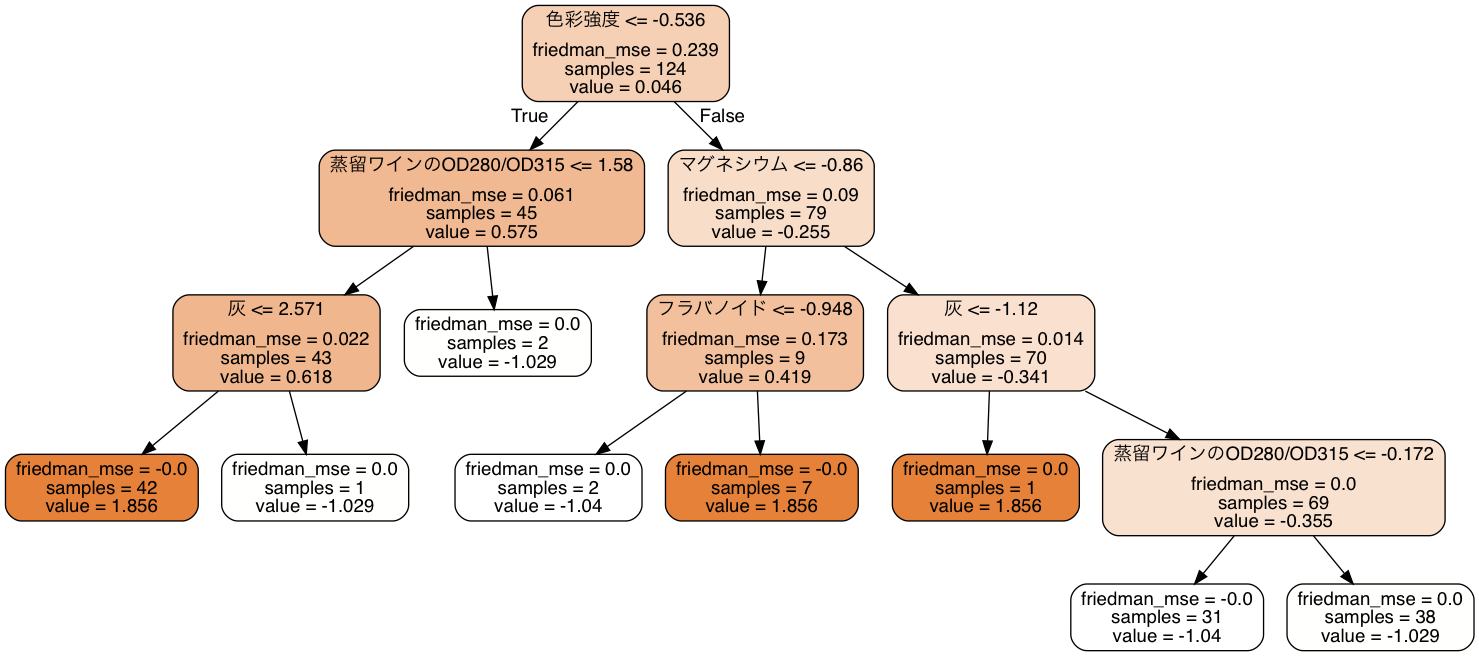

In [66]:
import pydotplus
from IPython.display import Image
from graphviz import Digraph
from sklearn.externals.six import StringIO
from sklearn.tree import export_graphviz

# 特徴量と分類の名前を取得
feature_names = wine.feature_names
feature_names_jp = ['アルコール','リンゴ酸','灰','灰のアルカリ性','マグネシウム',
                   'フェノール類全量','フラバノイド','非フラバノイドフェノール類','プロアントシアニン',
                   '色彩強度','色調','蒸留ワインのOD280/OD315','プロリン']
class_names = wine.target_names
class_names_jp = ['一級', '二級', '三級']

# GBDTモデルから、決定木のリストを取得(木の総数=学習数*)
tree_list = model.estimators_
print(tree_list[0][0])
print(len(tree_list))
print(len(tree_list[0]))

dot_data = StringIO()
export_graphviz(tree_list[0][1],  # 決定木オブジェクトを一つ指定する
                out_file=dot_data,
                feature_names=feature_names_jp, # チャートに表示される特徴量の名前
                class_names=class_names_jp,     # チャートに表示される分類名
                filled=True,  # Trueにすると、多く分類された方を色で示す
                rounded=True, # Trueにすると、ノードの角を丸く描画する
                max_depth=5)

graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

## PDFで外部出力する場合
# graph.write_pdf("graph.pdf")

### 変数重要度の可視化

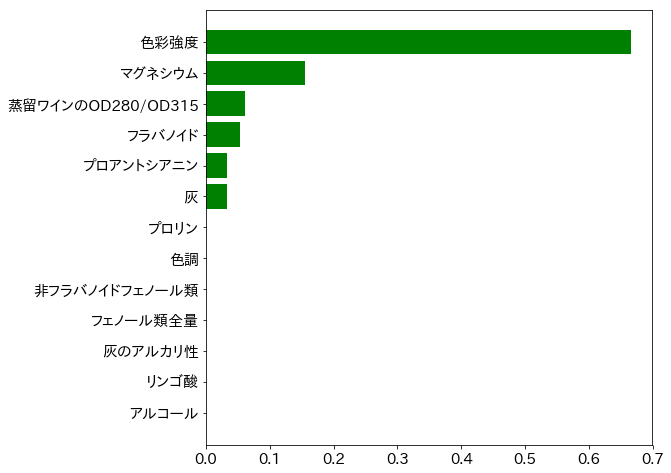

In [9]:
import matplotlib.pyplot as plt

# グラフに日本語を表示するための設定
plt.rcParams['font.family'] = 'IPAPGothic' #全体のフォントを設定
plt.rcParams['font.size'] = 20 #フォントサイズを設定 default : 12
plt.rcParams['xtick.labelsize'] = 15 # 横軸のフォントサイズ
plt.rcParams['ytick.labelsize'] = 15

# グラフ表示用の日本語リスト
feature_names_jp = ['アルコール', 'リンゴ酸','灰','灰のアルカリ性','マグネシウム',
                   'フェノール類全量','フラバノイド','非フラバノイドフェノール類','プロアントシアニン',
                   '色彩強度','色調','蒸留ワインのOD280/OD315','プロリン']

# GBDTモデルから、決定木のリストを取得(木の総数=学習数*)
tree_list = model.estimators_
importances = tree_list[100][1].feature_importances_
indices = np.argsort(importances)
feature_names_jp = np.array(feature_names_jp)

plt.figure(figsize=(8,8))
plt.barh(range(len(indices)), importances[indices], color='g', align='center')
plt.yticks(range(len(indices)), feature_names_jp[indices])
plt.show()

### 次元削減したデータで可視化
###### でもこれ13次元で学習したモデルのパラメータに2次元データ与えるの意味ないよなぁ・・

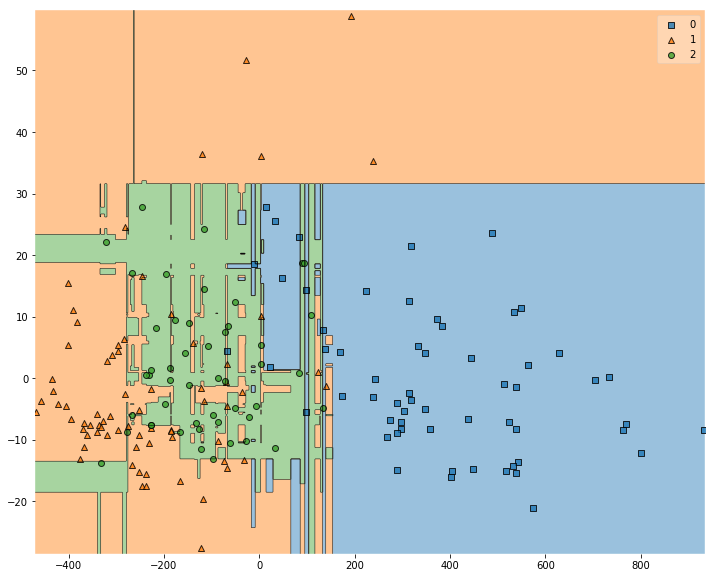

In [38]:
from sklearn import decomposition
pca = decomposition.PCA(n_components=2)
X = data
y = target
pca.fit(X)
transformed = pca.transform(X)

from sklearn import ensemble
model = ensemble.GradientBoostingClassifier(learning_rate=learning_rate,
                                            n_estimators=n_estimators,
                                            max_depth=max_depth,
                                            random_state=RANDOM_SEED)
model.fit(transformed, y)

from matplotlib import pyplot as plt
plt.figure(figsize=(12, 10))
from mlxtend.plotting import plot_decision_regions
plot_decision_regions(transformed, y, clf=model,  res=0.02)